In [1]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim

# Classification

In [32]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1', '2', '3', '4', '5']


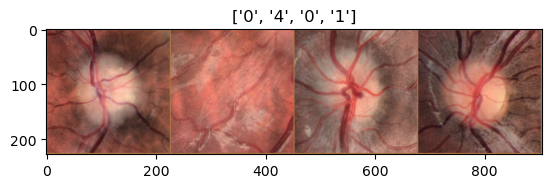

In [11]:
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [12]:
# siamese50simclr = get_feature_extractor(feature_extractor='resnet101', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
siamese50simclr = get_feature_extractor(feature_extractor='resnet50', cotrain=False, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')
siamese50simclr.fc = nn.Sequential(torch.nn.Linear(2048, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, 6))

load simclr resnet


In [13]:
# from torch.optim import lr_scheduler
siamese50simclr = siamese50simclr.to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': siamese50simclr.fc.parameters()}], lr=lr, momentum=momentum)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.8)

In [14]:
# bestmodel = siamese50simclr
valaccmax = 0
for e in range(50):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0

    for inputs, labels in dataloaders['train']:
        siamese50simclr.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        outputs = siamese50simclr(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item() * inputs.size(0)
        training_acc += torch.sum(preds == labels.data)

    for inputs, labels in dataloaders['val']:
        siamese50simclr.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = siamese50simclr(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

        val_acc += torch.sum(preds == labels.data)

        if(val_acc > valaccmax):
            valaccmax = val_acc
            torch.save(siamese50simclr.state_dict(), './pretrained/best-siamese50simclr.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'])

E0 With LR 0.01 training acc:  0.5405405405405406 Val acc:  0.5662650602409639 traning loss:  1.371166164810593
E1 With LR 0.01 training acc:  0.5557432432432432 Val acc:  0.5301204819277109 traning loss:  1.2303942369448173
E2 With LR 0.01 training acc:  0.5540540540540541 Val acc:  0.6144578313253012 traning loss:  1.1698590231102866
E3 With LR 0.01 training acc:  0.5608108108108109 Val acc:  0.6144578313253012 traning loss:  1.11409387777786
E4 With LR 0.008 training acc:  0.5557432432432432 Val acc:  0.6024096385542169 traning loss:  1.113829290041247
E5 With LR 0.008 training acc:  0.606418918918919 Val acc:  0.6506024096385542 traning loss:  1.0521692396015734
E6 With LR 0.008 training acc:  0.6030405405405406 Val acc:  0.6626506024096386 traning loss:  1.0867190346927256
E7 With LR 0.008 training acc:  0.5929054054054054 Val acc:  0.6385542168674698 traning loss:  1.057475238937784
E8 With LR 0.008 training acc:  0.6385135135135135 Val acc:  0.6265060240963856 traning loss:  1.0

## Testing and Evaluation

In [ ]:
# bestmodel = get_feature_extractor(feature_extractor='resnet101', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
bestmodel = get_feature_extractor(feature_extractor='resnet50', cotrain=False, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')

bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, 64),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(64, len(class_names)))
bestmodel.load_state_dict(torch.load('./pretrained/best-siamese50simclr.pt'))
bestmodel.to(device)

In [47]:
test_acc = 0
predlist = []
labelist = []
problist = []
test_embeddings = torch.zeros((0, 2048))
fextractor = torch.nn.Sequential(*(list(bestmodel.children())[:-1]))

for inputs, labels in dataloaders['train']:
    bestmodel.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = bestmodel(inputs)
        emb = fextractor(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)

    problist.append(outputs[:,1].detach().cpu().numpy())
    labelist.append(labels.detach().cpu().numpy()*1)
    predlist.append(preds.detach().cpu().numpy())
    test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
    test_acc += torch.sum(preds == labels.data)

labelist = np.concatenate(labelist).ravel()
problist = np.concatenate(problist).ravel()
predlist = np.concatenate(predlist).ravel()
test_embeddings = np.array(test_embeddings)

### F1 Acc Confusion Matrix AUC-ROC

In [48]:
print("test_acc acc: ", test_acc / dataset_sizes['test'])

test_acc acc:  tensor(2.6092, device='cuda:0')


In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(classification_report(labelist, predlist, digits=3))

              precision    recall  f1-score   support

           0      0.855     0.900     0.877       329
           1      0.759     0.779     0.769        77
           2      0.756     0.523     0.618        65
           3      0.761     0.467     0.579        75
           4      0.377     0.541     0.444        37
           5      0.391     1.000     0.562         9

    accuracy                          0.767       592
   macro avg      0.650     0.702     0.642       592
weighted avg      0.783     0.767     0.765       592



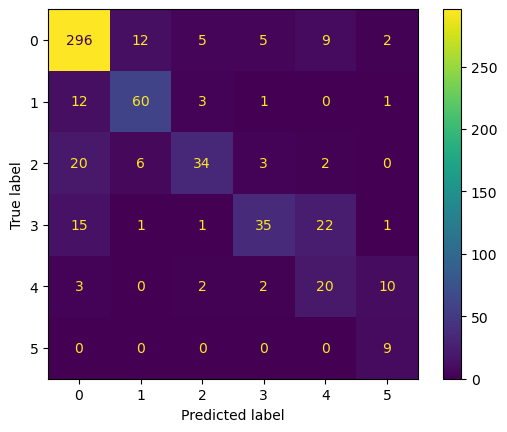

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
import sklearn.metrics as metrics

y_test = (labelist)
y_pred =(problist)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
roc_auc_score(y_test, y_pred)

### GradCAM

In [24]:
# siamese50simclr = RankNet_wresnet(feature_extractor='resnet101', cotrain=False).fextractor
for param in bestmodel.parameters():
    param.requires_grad = True

In [26]:
X, y = next(iter(dataloaders['test']))
print('True label : ', y, ' and predicted: ', torch.max(bestmodel(X.cuda()),1)[1])

True label :  tensor([1, 3, 2, 0])  and predicted:  tensor([0, 4, 0, 0], device='cuda:0')


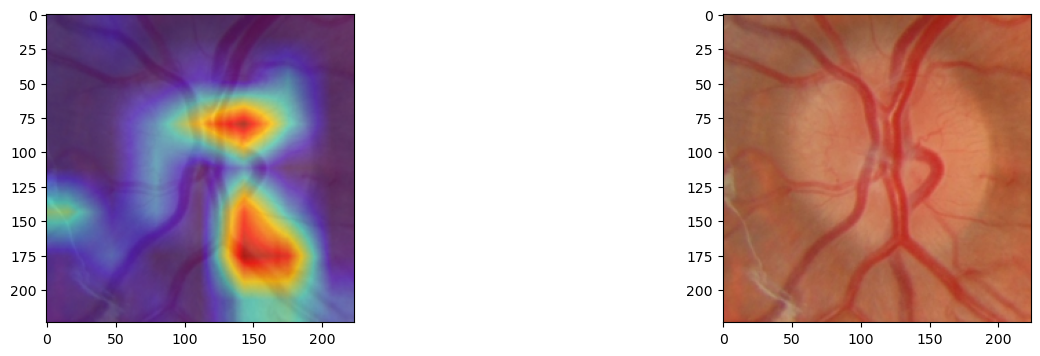

In [27]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model = bestmodel.eval()
target_layers = [model.layer4[-1]]

input_tensorA = X[0].unsqueeze(0)
rgb_imgA = imgtensor2array(X[0], mean=mean, std=std)
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
grayscale_camA = cam(input_tensor=input_tensorA, targets=[ClassifierOutputTarget(0)])

visualizationA = show_cam_on_image(rgb_imgA, grayscale_camA[0, :], use_rgb=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
ax = axes.ravel()

ax[0].imshow(visualizationA, label= 'heatmap A')
ax[1].imshow(rgb_imgA, label= 'heatmap A')


### Plot TSNE

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 592 samples in 0.001s...
[t-SNE] Computed neighbors for 592 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 592 / 592
[t-SNE] Mean sigma: 2.441875
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.895302
[t-SNE] KL divergence after 1000 iterations: 0.984831


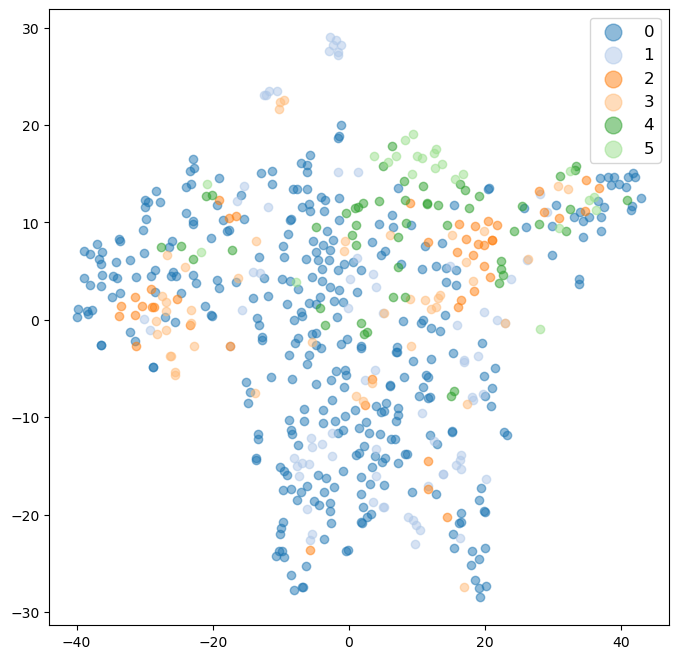

In [54]:
tsne = TSNE(2, verbose=1, n_iter=1000)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = predlist==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Similarity Comparison

In [3]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':100, 'val':100, 'test':100}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


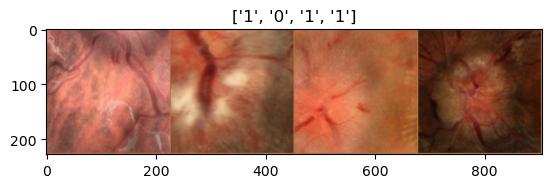

In [4]:
(inputs, _), classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes], mean=mean, std=std)

In [54]:
# siamese50simclr = get_feature_extractor(feature_extractor='resnet101', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
# siamese50simclr.fc = nn.Sequential(torch.nn.Linear(2048, 256),
#                                 torch.nn.ReLU(),
#                                 torch.nn.Dropout(0.1),
#                                 torch.nn.Linear(256, 64),
#                                 torch.nn.ReLU(),
#                                 torch.nn.Dropout(0.1),
#                                 torch.nn.Linear(64, 2))

load simclr resnet


In [5]:
class SiameseNetwork101(nn.Module):
    """
    Siamese neural network
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    Siamese ResNet-101 from Pytorch library
    """ 
    def __init__(self):
        super(SiameseNetwork101, self).__init__()
        # note that resnet101 requires 3 input channels, will repeat grayscale image x3
        self.cnn1 = get_feature_extractor(feature_extractor='resnet101', cotrain=False)# , simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_10_02102023.pth.tar')
        self.cnn1.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, 6))
    
    def forward_once(self, x):
        output = self.cnn1(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    Modified from: https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7

    """ 

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [15]:
# from torch.optim import lr_scheduler
siamese50simclr = SiameseNetwork101().to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': siamese50simclr.cnn1.fc.parameters()}], lr=lr, momentum=momentum)
loss_fn = ContrastiveLoss()
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.9)

In [18]:
valaccmax = 0
trainlosslist = []
trainacclist  = []
for e in range(50):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0
    for inputs, labels in dataloaders['train']:
        siamese50simclr.train()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        output1, output2 = siamese50simclr(inputA, inputB)
        preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
        loss = loss_fn(output1, output2, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item()
        training_acc += torch.sum(preds == labels.data)
        trainlosslist.append(training_loss_test)
        trainacclist.append(training_acc)
        
    for inputs, labels in dataloaders['val']:
        siamese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = siamese50simclr(inputA, inputB)
            preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            val_acc += torch.sum(preds == labels.data)

        if(val_acc > valaccmax):
            valaccmax = val_acc
            torch.save(siamese50simclr.state_dict(), './pretrained/best-contrastive101.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'])

E0 With LR 0.0016677181699666583 training acc:  0.39 Val acc:  0.55 traning loss:  0.26681953847408296
E1 With LR 0.0016677181699666583 training acc:  0.52 Val acc:  0.71 traning loss:  0.30239593744277954
E2 With LR 0.0016677181699666583 training acc:  0.49 Val acc:  0.57 traning loss:  0.3261661463975906
E3 With LR 0.0015009463529699924 training acc:  0.51 Val acc:  0.55 traning loss:  0.23733150362968444
E4 With LR 0.0015009463529699924 training acc:  0.49 Val acc:  0.55 traning loss:  0.2814667972922325
E5 With LR 0.0015009463529699924 training acc:  0.47 Val acc:  0.53 traning loss:  0.2620496067404747
E6 With LR 0.0013508517176729932 training acc:  0.5 Val acc:  0.57 traning loss:  0.2635236544907093
E7 With LR 0.0013508517176729932 training acc:  0.48 Val acc:  0.58 traning loss:  0.22868871212005615
E8 With LR 0.0013508517176729932 training acc:  0.55 Val acc:  0.47 traning loss:  0.2888095550239086
E9 With LR 0.001215766545905694 training acc:  0.57 Val acc:  0.39 traning loss

KeyboardInterrupt: 

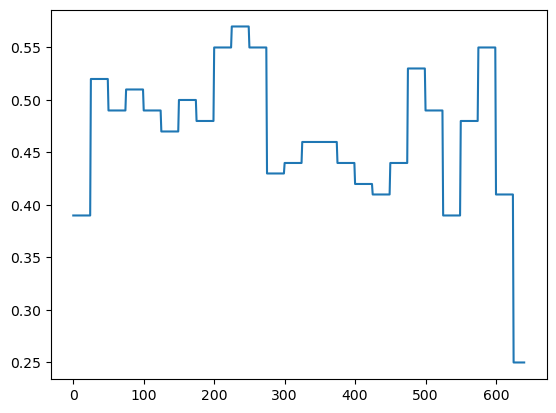

In [27]:
plt.plot(torch.stack(trainacclist).cpu()/100)

# Prefered Comparison